# Get State of the Art

Here for we compare published models to get the current state of the art

In [1]:
import pandas as pd
from model_predictions import model_prediction_list
from datasets import dataset_list
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
from scipy import stats
import seaborn as sns
import gpplot

We'll load and get unique sgRNAs for published datasets and models

In [2]:
for mp in model_prediction_list:
    mp.load_model_predictions()
    mp.get_sgrnas()

for ds in dataset_list:
    ds.load_data()
    ds.get_sgrnas()

model_datasets = model_prediction_list + dataset_list

In [3]:
model_data_summaries = []
for data in model_datasets:
    summary = {}
    summary['name'] = data.name
    summary['data_type'] = data.classtype
    summary['n_sgRNAs'] = len(data.sgrnas)
    model_data_summaries.append(summary)

model_data_summary_df = pd.DataFrame(model_data_summaries)
model_data_summary_df.sort_values('n_sgRNAs')

,name,data_type,n_sgRNAs
10,Kim2019_test,dataset,536
7,Doench2014_human,dataset,995
13,Wang2014,dataset,1022
4,Chari2015,dataset,1145
6,Doench2014_mouse,dataset,1168
8,Doench2016,dataset,2536
5,DeWeirdt2020,dataset,3510
0,Rule Set 2,model,4379
12,Shalem_2014,dataset,4766
11,Koike-Yusa2014,dataset,6689


## Overlap between datasets and models

For each dataset and model we'll calculate the fraction of sgRNAs that each library shares with one another

In [4]:
dataset_overlaps = []
for ds1 in model_datasets:
    for ds2 in model_datasets:
        if ds1.name != ds2.name:
            dataset_overlap = {}
            dataset_overlap['name_1'] = ds1.name
            dataset_overlap['name_2'] = ds2.name
            common_sgrnas = (pd.Series(list(ds1.sgrnas))
                             .isin(list(ds2.sgrnas))
                             .sum())
            dataset_overlap['overlap'] = common_sgrnas
            dataset_overlaps.append(dataset_overlap)

dataset_overlap_df = pd.DataFrame(dataset_overlaps)
filtered_overlap = dataset_overlap_df[dataset_overlap_df['overlap'] > 0].reset_index(drop=True)
filtered_overlap = (filtered_overlap.merge(model_data_summary_df
                                           .rename({'name': 'name_1'}, axis=1),
                                           how='inner', on='name_1')
                    .merge(model_data_summary_df
                           .rename({'name': 'name_2'}, axis=1),
                           how='inner', on='name_2', suffixes=('_1', '_2')))
filtered_overlap['fraction_overlap'] = filtered_overlap['overlap']/filtered_overlap['n_sgRNAs_1']

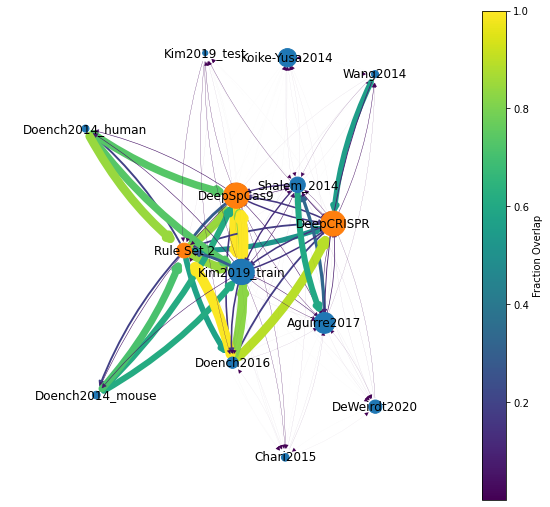

In [5]:
G = nx.from_pandas_edgelist(filtered_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (model_data_summary_df[['name', 'n_sgRNAs', 'data_type']]
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(10,9))
# layout
pos = nx.spring_layout(G, seed=7)
# edges
edge_width = [d['fraction_overlap']*10 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-|>", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.05 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['data_type'] == 'dataset' else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.margins(x=0.2)

## Model Performance



In [6]:
model_comparison_list = []
for i in range(len(model_prediction_list)):
    for j in range(i+1, len(model_prediction_list)):
        pred1 = model_prediction_list[i]
        pred2 = model_prediction_list[j]
        joined_predictions = pred1.prediction_df.merge(pred2.prediction_df, how='inner',
                                                       on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        filtered_predictions = joined_predictions[~joined_predictions['sgRNA Sequence'].isin(pred1.sgrnas) &
                                                  ~joined_predictions['sgRNA Sequence'].isin(pred2.sgrnas)]
        for ds in dataset_list:
            ds_predictions = filtered_predictions.merge(ds.dataset, how='inner',
                                                        left_on=['sgRNA Sequence', 'sgRNA Context Sequence'],
                                                        right_on=[ds.sgrna_seq_col, ds.context_seq_col])
            if ds_predictions.shape[0] > 50:
                performance_dict = {}
                performance_dict['model1'] = pred1.name
                performance_dict['model2'] = pred2.name
                performance_dict['dataset'] = ds.name
                performance_dict['size'] = ds_predictions.shape[0]
                performance_dict['model1_spearman'] = stats.spearmanr(ds_predictions[pred1.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                performance_dict['model2_spearman'] = stats.spearmanr(ds_predictions[pred2.prediction_col],
                                                                      ds_predictions[ds.rank_col])[0]
                model_comparison_list.append(performance_dict)

performance_df = pd.DataFrame(model_comparison_list)
performance_df['difference'] = performance_df['model1_spearman'] - performance_df['model2_spearman']
performance_df['dataset'] = performance_df['dataset'].astype('category')
performance_df.head()

,model1,model2,dataset,size,model1_spearman,model2_spearman,difference
0,Rule Set 2,DeepSpCas9,Aguirre2017,8210,0.468766,0.511899,-0.043134
1,Rule Set 2,DeepSpCas9,Chari2015,1117,0.385993,0.445367,-0.059374
2,Rule Set 2,DeepSpCas9,DeWeirdt2020,3502,0.216843,0.223068,-0.006224
3,Rule Set 2,DeepSpCas9,Doench2014_mouse,329,0.309187,0.407365,-0.098178
4,Rule Set 2,DeepSpCas9,Doench2014_human,154,0.278753,0.291524,-0.012772


We can see that DeepSpCas9 consistently outperforms Rule Set 2, and DeepCRISPR is consistently the worst model

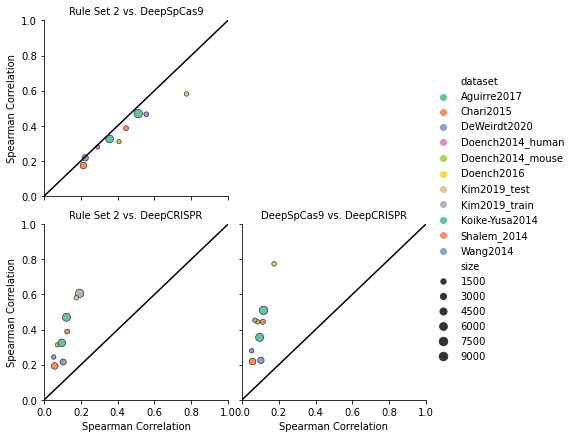

In [7]:
def const_line(*args, **kwargs):
    plt.plot([0, 1], [0, 1], color='black')
    
    
g = sns.FacetGrid(data=performance_df, col='model1', row='model2')
g.map(const_line)
g.map_dataframe(sns.scatterplot, y='model1_spearman', x='model2_spearman', 
                hue='dataset', size='size', palette='Set2',
                edgecolor='black', linewidth=0.5)
g.set_titles(template="{col_name} vs. {row_name}")
g.set_axis_labels("Spearman Correlation", "Spearman Correlation")
g.add_legend()
g.set(xlim=(0,1), ylim=(0,1))
for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()
        ax.set_title('')

In [8]:
average_difference = (performance_df.groupby(['model1', 'model2'])
                      .apply(lambda df: ((df['model1_spearman'] - df['model2_spearman'])*df['size']).sum()/
                                        df['size'].sum())
                      .reset_index(name='avg_difference'))
average_difference

,model1,model2,avg_difference
0,DeepSpCas9,DeepCRISPR,0.280020
1,Rule Set 2,DeepCRISPR,0.286312
2,Rule Set 2,DeepSpCas9,-0.040622


## Picking training data
Since DeepSpCas9 is the current state of art, we'll start with the Kim2019_train data as our training seed, and then include all data with more than 50% overlap with the Kim2019_train data, as well as the Koike-Yusa2014 data to expand the training set.

In [9]:
dataset_overlap = filtered_overlap[(filtered_overlap['data_type_1'] == 'dataset') &
                                   (filtered_overlap['data_type_2'] == 'dataset')].copy()

In [10]:
def get_overlapping_datasets(datasets, sink_node, data, threshold=0.2):
    datasets.append(sink_node)
    overlapping_nodes = data.loc[(data['name_2'] == sink_node) &
                                 (data['fraction_overlap'] > threshold), 
                                 'name_1'].to_list()
    if len(overlapping_nodes) != 0:
        filtered_data = data[~data['name_1'].isin(overlapping_nodes)].copy()
        for node in overlapping_nodes:
            get_overlapping_datasets(datasets, node, filtered_data, threshold)
            
train_datasets = []
get_overlapping_datasets(train_datasets, 'Kim2019_train', dataset_overlap)
get_overlapping_datasets(train_datasets, 'Wang2014', dataset_overlap)
train_datasets

['Kim2019_train',
 'Doench2014_mouse',
 'Doench2014_human',
 'Doench2016',
 'Wang2014']

In [11]:
sgrna_train_dfs_list = list()
sgrna_test_dfs_list = list()
for ds in dataset_list:
    if ds.name in train_datasets:
        sgrna_train_dfs_list.append(ds.get_sg_df())
    else:
        sgrna_test_dfs_list.append(ds.get_sg_df())
        

train_sgrna_df = (pd.concat(sgrna_train_dfs_list)
                  .drop_duplicates())
test_sgrna_df = (pd.concat(sgrna_test_dfs_list)
                 .drop_duplicates())
print("Train sgRNAs: " + str(train_sgrna_df.shape[0]))
print("Test sgRNAs: " + str(test_sgrna_df.shape[0]))

Train sgRNAs: 15004
Test sgRNAs: 22375


In [12]:
data_summary_df = model_data_summary_df.loc[model_data_summary_df['data_type'] == 'dataset', 
                                            ['name', 'n_sgRNAs']].copy()
data_summary_df['Train'] = data_summary_df['name'].isin(train_datasets)

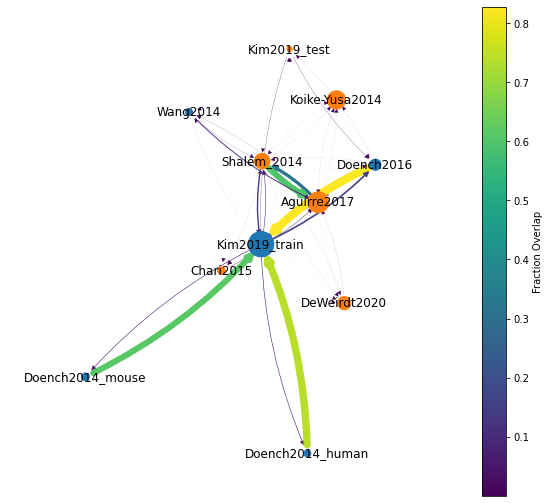

In [13]:
G = nx.from_pandas_edgelist(dataset_overlap, 'name_1', 'name_2', 'fraction_overlap',
                            create_using=nx.DiGraph())
node_n_sgrnas = (data_summary_df
                 .set_index('name')
                 .to_dict(orient='index'))
nx.set_node_attributes(G, node_n_sgrnas)
plt.subplots(figsize=(10,9))
# layout
pos = nx.spring_layout(G, seed=7)
# edges
edge_width = [d['fraction_overlap']*10 for u, v, d in G.edges(data=True)]
edge_color_scale = [d['fraction_overlap'] for u, v, d in G.edges(data=True)]
edges = nx.draw_networkx_edges(G, pos, arrowstyle="-|>", connectionstyle="arc3,rad=0.1",
                               width=edge_width, edge_color=edge_color_scale)
pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.viridis)
pc.set_array(edge_color_scale)
plt.colorbar(pc, label='Fraction Overlap')
# nodes
node_size = [d['n_sgRNAs'] * 0.05 for _, d in G.nodes(data=True)]
node_color = ['tab:blue' if d['Train'] else 'tab:orange' for _, d in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
# labels
nx.draw_networkx_labels(G, pos)
plt.axis('off')
plt.margins(x=0.2)

## Write list of training data

In [14]:
train_data_name_df = pd.DataFrame({'name': train_datasets})
train_data_name_df.to_csv('../data/processed/train_data_names.csv', index=False)